In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

import scipy.io as sio
import librosa

import time

import skimage
import skimage.io
from skimage.transform import rescale

from scipy.io import wavfile
import os
import subprocess

import sys
sys.path.append("../src")
from spectrogramtools import *
from stego import *
from swpowerstego import *
from imtools import *
from tsp import *
from curvature import *


0
1092
2146
3187


(17.15, 563.85, -31.65, 686.65)

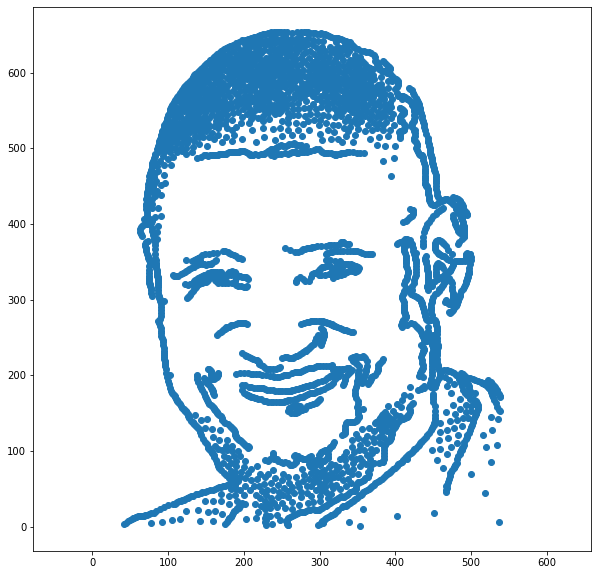

In [2]:
# Image parameters
thresh = 0.1
p = 1
canny_sigma = 3
density_fac= 1
edge_weight = 10
target_points = 4000

np.random.seed(0)
I = skimage.io.imread("../data/images/usher.jpg")

X = voronoi_stipple(I, thresh, target_points=target_points, p=p, canny_sigma=canny_sigma, edge_weight=edge_weight, n_iters=10, do_plot=False)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1])
plt.axis("equal")

Text(0.5, 1.0, 'After resampling/smoothing')

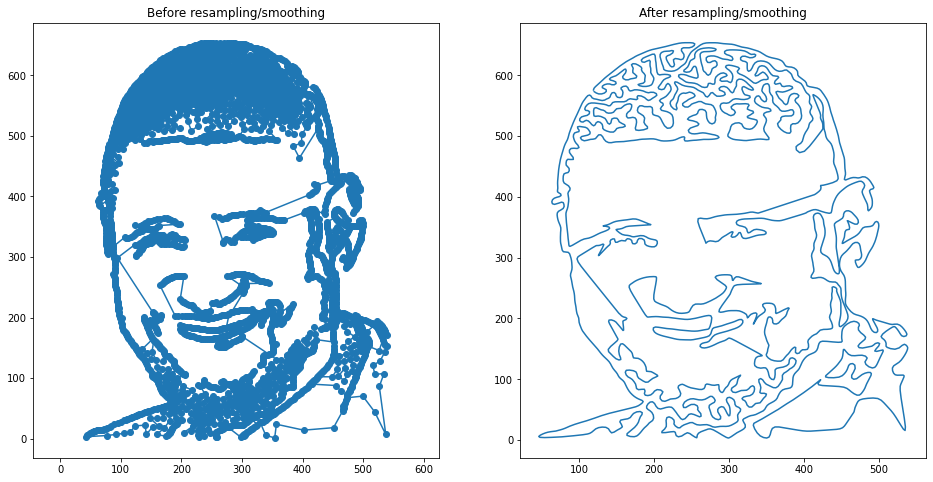

In [3]:
#X = density_filter(X, fac=density_fac, k=2)
X = get_tsp_tour(X)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(X[:, 0], X[:, 1])
plt.scatter(X[:, 0], X[:, 1])
plt.axis("equal")
plt.title("Before resampling/smoothing")

s = get_arclen(get_curv_vectors(X, 0, 1, loop=True)[1])
X = arclen_resample(X, s, X.shape[0])
sigma = 1
X = get_curv_vectors(X, 0, sigma, loop=True)[0]
plt.subplot(122)
plt.plot(X[:, 0], X[: ,1])
plt.title("After resampling/smoothing")

## Load in audio and compute best target

In [ ]:
# Audio parameters
x, sr = librosa.load("../data/tunes/usher-baby.mp3", sr=44100)
win_length = 1024
freqs = [1, 2]
print([int(fi*sr/win_length) for fi in freqs])

# Sliding window parameters
win = 16
fit_lam = 0.01
q = -1

max_ratio = 0
freq_idxs = [freqs[0], freqs[1]] # Some of the most active
freq_idxs = sorted(freq_idxs)

sp = STFTPowerDisjoint(x, X, win_length, freq_idxs, win, fit_lam, q, do_viterbi=True)
sp.plot(normalize=False)

sp.solve()
sp.plot(normalize=True)

/home/ctralie/anaconda3/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[43, 86]
Diff Before Viterbi 624090607.7595316
viterbi_K =  11
Diff After Viterbi 295914854.47892606
Computing target coordinate 1 of 2...

Elapsed time: 2.645
Computing target coordinate 2 of 2...



In [ ]:
y = sp.reconstruct_signal()
ipd.Audio(y, rate=sr)

In [ ]:
prefix = "SpecPower_Win{}_fit{:.3g}_stftwin{}_freqs{}_{}_q{}".format(win, fit_lam, win_length, freq_idxs[0], freq_idxs[1], q)
filename = "{}.mp3".format(prefix)
wavfile.write("out.wav", sr, y)
if os.path.exists(filename):
    os.remove(filename)
subprocess.call("ffmpeg -i out.wav".split() + [filename], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
os.remove("out.wav")

z, sr = librosa.load(filename, sr=sr)
z_sp = STFTPowerDisjoint(z, X, win_length, freq_idxs, win, fit_lam, q, viterbi_iters=0)
z_sp.MagSolver.targets = sp.MagSolver.targets
snr = get_snr(x, z)
distortion = z_sp.get_distortion()[0]
ratio = snr/distortion

fhz = [fi*sr/win_length for fi in freq_idxs]
title = "snr = {:.3f}, distortion = {:.3f}, f1 = {:.1f} hz, f2 = {:.1f}hz".format(snr, distortion, fhz[0], fhz[1])

plt.figure(figsize=(6, 6))
z_sp.plot(True, title)
plt.tight_layout()
plt.savefig("{}.png".format(prefix), facecolor='white')
